# Capstone Project: Predicting additional tax revenue for the state of Connecticut if sports wagering is legalized

## Problem Statement

The State Legislature of Connecticut is reviewing a bill to legalize sports wagering within the state. The State Legislature must carefully weigh pros and cons when deciding pass or reject the bill. If they pass the bill, the bill moves on to the Sentate for final approval. If the Senate approves, Connecticut would become the 12th state in the United States where sports wagering has been legalized.

A major consideration by the State Legislature is the potential revenue gain in the State General fund. All sources of gaming share revenue with the state and make transfers into the State General fund at the end of the fiscal year. While sports wagering itsself is likely to bring in new revenue for the state, the state must consider reductions in other revenue streams that the new sports wagering revenue stream may cause. 

Using Sports Wagering year-end reports we have for each state where sports wagering was legal in 2019 as well as state annual reports showing other streams of revenue, we will build and leverage an unsupervised linear regression model that will help predict if legazing sports wagering will lead to an increase or decrease in total revenue for Connectiut, using the other states as prototypes. After modeling, We will exmaine the model's mean squared error, helping us determine the success of the model. Our goal is to provide the state with a model that can predict revenue as closely as possible, giving the state more confidence to make their decision more clear.

In [129]:
import numpy as np
import pandas as pd
import time
import datetime as dt
import requests
import matplotlib.pyplot as plt
import regex as re
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

np.random.seed(42)
sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
df = pd.read_csv('./data/state_reports.csv')

In [3]:
df

,state,month,year,handle,revenue,taxes
0,NJ,1,2019,385279662.0,18777582,2532619
1,NJ,2,2019,320368087.0,12732740,1817553
2,NJ,3,2019,372451342.0,31669387,4180051
3,NJ,4,2019,313719562.0,21215747,2817206
4,NJ,5,2019,318940677.0,15536384,2135704
...,...,...,...,...,...,...
96,IN,11,2019,147276912.0,10593321,1006365
97,IN,12,2019,161808924.0,12068114,1146471
98,OR,10,2019,5603136.0,218107,196296
99,OR,11,2019,17089383.0,943687,849318


## Cleaning / EDA

In [4]:
df.info

<bound method DataFrame.info of     state  month  year       handle   revenue    taxes
0      NJ      1  2019  385279662.0  18777582  2532619
1      NJ      2  2019  320368087.0  12732740  1817553
2      NJ      3  2019  372451342.0  31669387  4180051
3      NJ      4  2019  313719562.0  21215747  2817206
4      NJ      5  2019  318940677.0  15536384  2135704
..    ...    ...   ...          ...       ...      ...
96     IN     11  2019  147276912.0  10593321  1006365
97     IN     12  2019  161808924.0  12068114  1146471
98     OR     10  2019    5603136.0    218107   196296
99     OR     11  2019   17089383.0    943687   849318
100    OR     12  2019   22375049.0   1632412  1469171

[101 rows x 6 columns]>

In [5]:
df.columns

Index(['state', 'month', 'year', 'handle', 'revenue', 'taxes'], dtype='object')

In [6]:
df.shape

(101, 6)

In [7]:
df.count

<bound method DataFrame.count of     state  month  year       handle   revenue    taxes
0      NJ      1  2019  385279662.0  18777582  2532619
1      NJ      2  2019  320368087.0  12732740  1817553
2      NJ      3  2019  372451342.0  31669387  4180051
3      NJ      4  2019  313719562.0  21215747  2817206
4      NJ      5  2019  318940677.0  15536384  2135704
..    ...    ...   ...          ...       ...      ...
96     IN     11  2019  147276912.0  10593321  1006365
97     IN     12  2019  161808924.0  12068114  1146471
98     OR     10  2019    5603136.0    218107   196296
99     OR     11  2019   17089383.0    943687   849318
100    OR     12  2019   22375049.0   1632412  1469171

[101 rows x 6 columns]>

In [10]:
df.describe

<bound method NDFrame.describe of     state  month  year       handle   revenue    taxes
0      NJ      1  2019  385279662.0  18777582  2532619
1      NJ      2  2019  320368087.0  12732740  1817553
2      NJ      3  2019  372451342.0  31669387  4180051
3      NJ      4  2019  313719562.0  21215747  2817206
4      NJ      5  2019  318940677.0  15536384  2135704
..    ...    ...   ...          ...       ...      ...
96     IN     11  2019  147276912.0  10593321  1006365
97     IN     12  2019  161808924.0  12068114  1146471
98     OR     10  2019    5603136.0    218107   196296
99     OR     11  2019   17089383.0    943687   849318
100    OR     12  2019   22375049.0   1632412  1469171

[101 rows x 6 columns]>

In [11]:
df.columns

Index(['state', 'month', 'year', 'handle', 'revenue', 'taxes'], dtype='object')

In [90]:
df.dtypes

state       object
month      float64
year         int64
handle     float64
revenue      int64
taxes        int64
cluster      int32
color       object
dtype: object

In [91]:
df['month'] = df.month.astype(float)
df['handle'] = df.handle.astype(float)
df['taxes'] = df.taxes.astype(float)
df['revenue'] = df.revenue.astype(float)

In [92]:
df.dtypes

state       object
month      float64
year         int64
handle     float64
revenue    float64
taxes      float64
cluster      int32
color       object
dtype: object

In [13]:
df.isnull().sum().sort_values(ascending = False)

handle     6
taxes      0
revenue    0
year       0
month      0
state      0
dtype: int64

In [14]:
df[df.isna().any(axis=1)]


,state,month,year,handle,revenue,taxes
83,NY,7,2019,NaN,349468,34947
84,NY,8,2019,NaN,828152,82815
85,NY,9,2019,NaN,2283865,228387
86,NY,10,2019,NaN,2233227,223323
87,NY,11,2019,NaN,1308296,130830
88,NY,12,2019,NaN,780418,78042


In [15]:
df.loc[83, 'handle'] = 5098389
df.loc[84, 'handle'] = 12081910
df.loc[85, 'handle'] = 33319306
df.loc[86, 'handle'] = 32580549
df.loc[87, 'handle'] = 12086730
df.loc[88, 'handle'] = 11385518

In [16]:
df.isnull().sum().sort_values(ascending = False)

taxes      0
revenue    0
handle     0
year       0
month      0
state      0
dtype: int64

### Visualizing (this won't be an actual section)

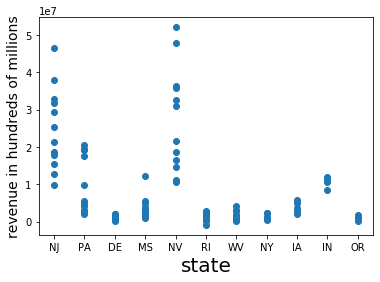

In [75]:
plt.scatter(df["state"], df["revenue"])
plt.xlabel("state", fontsize = 20)
plt.ylabel("revenue in hundreds of millions", fontsize = 14);

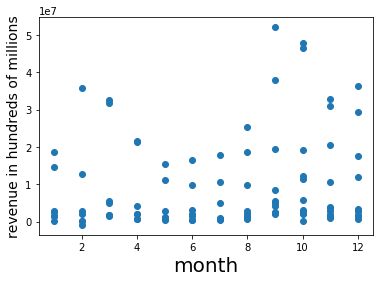

In [74]:
plt.scatter(df['month'], df['revenue'])
plt.xlabel("month", fontsize = 20)
plt.ylabel("revenue in hundreds of millions", fontsize = 14);

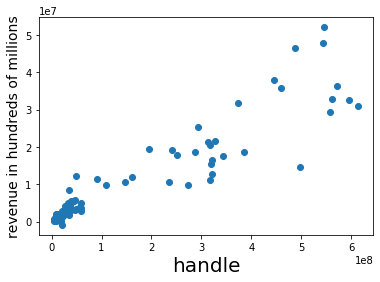

In [73]:
plt.scatter(df['handle'], df['revenue'])
plt.xlabel('handle', fontsize = 20)
plt.ylabel('revenue in hundreds of millions', fontsize = 14);

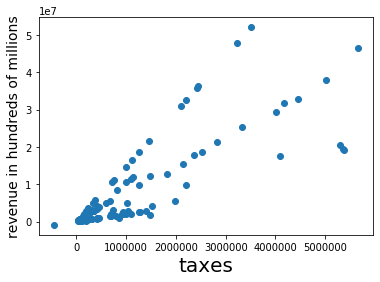

In [76]:
plt.scatter(df['taxes'], df['revenue'])
plt.xlabel('taxes', fontsize = 20)
plt.ylabel('revenue in hundreds of millions', fontsize = 14);

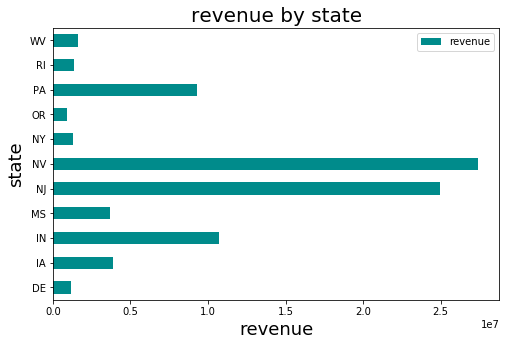

In [77]:
df.groupby("state")[["revenue"]].mean().plot(kind = "barh", color="darkcyan", figsize=(8,5))
plt.ylabel("state", fontsize=18)
plt.xlabel("revenue", fontsize=18)
plt.title("revenue by state", fontsize=20);

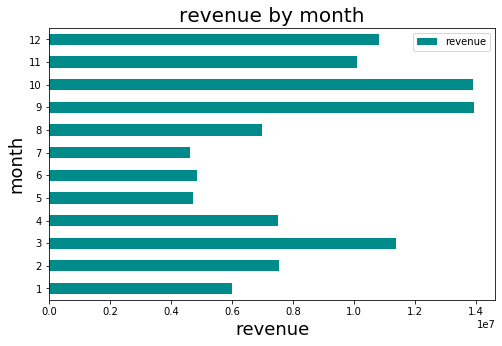

In [25]:
df.groupby("month")[["revenue"]].mean().plot(kind = "barh", color="darkcyan", figsize=(8,5))
plt.ylabel("month", fontsize=18)
plt.xlabel("revenue", fontsize=18)
plt.title("revenue by month", fontsize=20);

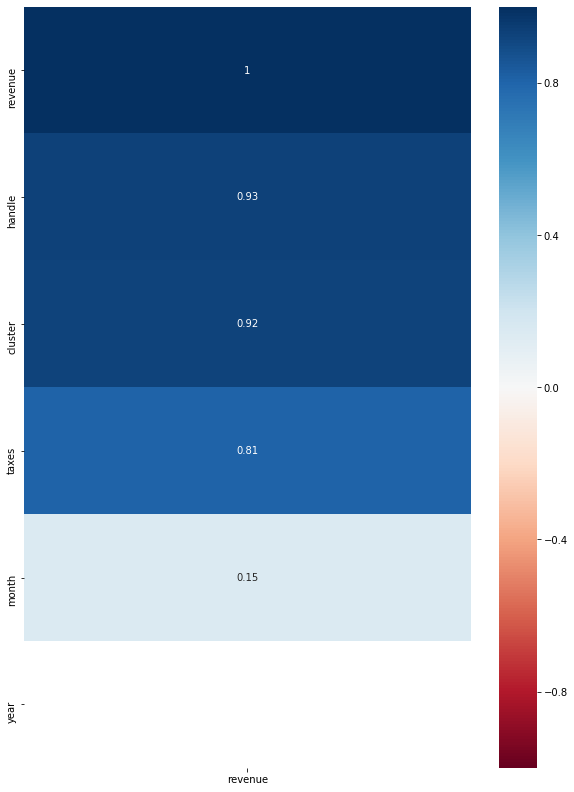

In [78]:
#Heatmap of the corrleations of features and SalePrice

plt.figure(figsize = (10,14))
sns.heatmap(df.corr()[["revenue"]].sort_values(by = 'revenue', ascending = False),
                            annot = True,
                            cmap="RdBu",
                            vmin = -1,
                            vmax = 1);

## Preprocessing 

### PCA


In [97]:
df.dtypes

state       object
month      float64
year         int64
handle     float64
revenue    float64
taxes      float64
cluster      int32
color       object
dtype: object

In [93]:
non_revenue_cols = ["month", "handle", "taxes"]

In [99]:
# Assigning the new columns to a variable

non_revenue_cols_2 = df[non_revenue_cols]

In [101]:
non_revenue_cols_2.head()

,month,handle,taxes
0,1.0,385279662.0,2532619.0
1,2.0,320368087.0,1817553.0
2,3.0,372451342.0,4180051.0
3,4.0,313719562.0,2817206.0
4,5.0,318940677.0,2135704.0


In [102]:
ss = StandardScaler()

In [103]:
scale = ss.fit_transform(non_revenue_cols_2)

In [104]:
non = pd.DataFrame(scale, columns = non_revenue_cols)

In [107]:
non.head(10)

,month,handle,taxes
0,-1.759083,1.441440,0.947676
1,-1.470193,1.075255,0.436091
2,-1.181303,1.369072,2.126312
3,-0.892413,1.037749,1.151281
4,-0.603523,1.067203,0.663708
5,-0.314633,0.809296,0.036152
6,-0.025743,0.686025,0.829719
7,0.263147,0.924220,1.516428
8,0.552037,1.781518,2.725723
9,0.840927,2.020489,3.186661


### Using a PairGrid to visualize correlation

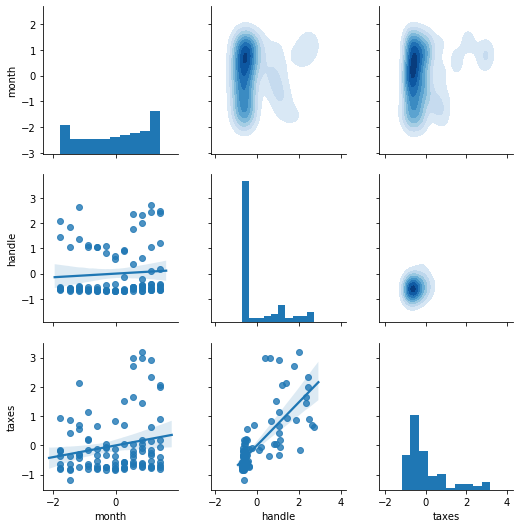

In [110]:
g = sns.PairGrid(non)
g = g.map_lower(sns.regplot) # Regression plots in lower triangle.
g = g.map_upper(sns.kdeplot, cmap="Blues", shade=True, shade_lowest=False)  # KDE plots in upper triangle.
g = g.map_diag(plt.hist) # Histograms along diagonal.

plt.show();

### Heat map to visualize correlation

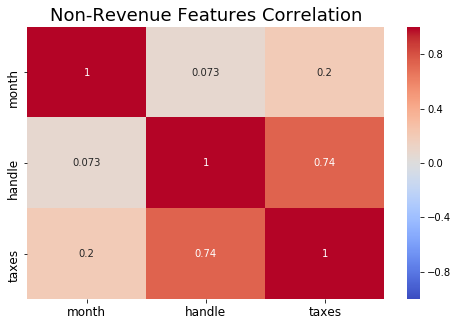

In [114]:
plt.figure(figsize = (8, 5))
plt.title("Non-Revenue Features Correlation", fontsize = 18);


sns.heatmap(non.corr(), 
            cmap ='coolwarm', 
            annot = True,
            vmax = 1,
            vmin = -1)
            
plt.xticks(fontsize = 12) 
plt.yticks(fontsize = 12); 

In [117]:
# Fitting PCA on the non-revenue features

non_pca = PCA(n_components=3)
non_pca.fit(non.values)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [118]:
# Examining the weights of the principal components

non_pca.components_

array([[ 0.24110184,  0.67599978,  0.69634345],
       [-0.96246913,  0.25866246,  0.08213952],
       [-0.12459161, -0.69001307,  0.71299291]])

In [122]:
# Examining the explained variance values and explained variance ratios

non_pca.explained_variance_ratio_

array([0.59516407, 0.32108527, 0.08375066])

In [126]:
# Transforming the data into the principal component space

# This will transform our our three-dimensional data set into vectors along its three principal components (with zero loss).

non_pca.transform(non.values)

array([[ 1.21020321e+00,  2.14375070e+00, -9.97590936e-02],
       [ 6.76075115e-01,  1.72896339e+00, -2.47836930e-01],
       [ 2.12132136e+00,  1.66574897e+00,  7.18548268e-01],
       [ 1.28804251e+00,  1.22191193e+00,  2.15981635e-01],
       [ 1.03808725e+00,  9.11433867e-01, -1.87970891e-01],
       [ 4.96399924e-01,  5.15128288e-01, -4.93448101e-01],
       [ 1.03531526e+00,  2.70378045e-01,  1.21425246e-01],
       [ 1.74417247e+00,  1.10348503e-01,  4.10692734e-01],
       [ 3.23544268e+00,  1.53382682e-01,  6.45371089e-01],
       [ 3.78760939e+00, -2.49911162e-02,  7.73130198e-01],
       [ 3.54365573e+00, -2.64580948e-01, -1.66819362e-01],
       [ 3.37355197e+00, -5.75844927e-01, -4.10177084e-01],
       [-9.31113276e-01,  1.53459235e+00,  4.62243088e-01],
       [-9.81851785e-01,  1.24182774e+00,  3.06966041e-01],
       [-2.21794958e-01,  1.05836776e+00,  8.76311704e-01],
       [-4.14498512e-01,  7.41542062e-01,  6.32184511e-01],
       [-5.91878506e-01,  4.33512167e-01

In [ ]:
# Comparing PCA-transformed features to features prior to being PCA-transformed

In [127]:
pd.DataFrame(non.values).head(10)

,0,1,2
0,-1.759083,1.441440,0.947676
1,-1.470193,1.075255,0.436091
2,-1.181303,1.369072,2.126312
3,-0.892413,1.037749,1.151281
4,-0.603523,1.067203,0.663708
5,-0.314633,0.809296,0.036152
6,-0.025743,0.686025,0.829719
7,0.263147,0.924220,1.516428
8,0.552037,1.781518,2.725723
9,0.840927,2.020489,3.186661


In [128]:
pd.DataFrame(non_pca.transform(non.values)).head(10)

,0,1,2
0,1.210203,2.143751,-0.099759
1,0.676075,1.728963,-0.247837
2,2.121321,1.665749,0.718548
3,1.288043,1.221912,0.215982
4,1.038087,0.911434,-0.187971
5,0.496400,0.515128,-0.493448
6,1.035315,0.270378,0.121425
7,1.744172,0.110349,0.410693
8,3.235443,0.153383,0.645371
9,3.787609,-0.024991,0.773130


### Using PCA ro reduce dimensionality

## Modeling

In [59]:
X = df.loc[:, ['month', 'revenue', 'handle', 'taxes']]

In [60]:
X.head()

,month,revenue,handle,taxes
0,1,18777582,385279662.0,2532619
1,2,12732740,320368087.0,1817553
2,3,31669387,372451342.0,4180051
3,4,21215747,313719562.0,2817206
4,5,15536384,318940677.0,2135704


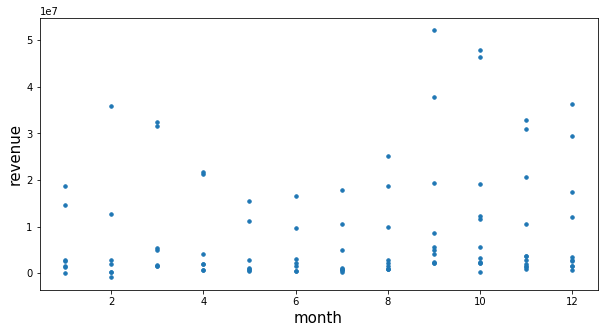

In [58]:
# For my reference

state_revenue_plot = df.plot(kind = "scatter", x = "month", y = "revenue",
             figsize=(10,5),
             s = 12)

plt.xlabel("month", fontsize = 15)
plt.ylabel("revenue", fontsize = 15)

state_revenue_plot.tick_params(axis = 'both',
               which = 'minor',
               labelsize = 14)

In [61]:
# Initializing an instance of KMeans
# K = 3 clusters

km = KMeans(n_clusters = 3)

In [62]:
# Fitting our sliced df

km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [63]:
# Assigning clusters

df["cluster"] = km.labels_

In [64]:
df.head(10)

,state,month,year,handle,revenue,taxes,cluster,color
0,NJ,1,2019,385279662.0,18777582,2532619,1,black
1,NJ,2,2019,320368087.0,12732740,1817553,1,black
2,NJ,3,2019,372451342.0,31669387,4180051,1,blue
3,NJ,4,2019,313719562.0,21215747,2817206,1,black
4,NJ,5,2019,318940677.0,15536384,2135704,1,black
5,NJ,6,2019,273222975.0,9701925,1258541,1,black
6,NJ,7,2019,251371272.0,17884790,2367745,1,pink
7,NJ,8,2019,293594862.0,25210342,3327589,1,blue
8,NJ,9,2019,445563503.0,37883375,5017875,2,blue
9,NJ,10,2019,487924504.0,46393537,5662148,2,blue


In [66]:
# Plotting the centroids from the model object with the scatter of 
# "month" and "revenue"

centroid = pd.DataFrame(km.cluster_centers_, columns = ["month", "revenue", "handle", "taxes"])
                                        

In [67]:
centroid.head()

,month,revenue,handle,taxes
0,7.095890,2.756441e+06,2.889667e+07,5.488931e+05
1,6.352941,1.811690e+07,3.008626e+08,2.699417e+06
2,8.181818,3.607794e+07,5.347260e+08,3.277243e+06


Plotting methodology:

1. Setting the plot figure with a fig size
2. Assigning colors to centroids
3. Mapping clusters
4. Setting up the plot of clusters
5. Adding the centroids to the plot

<Figure size 720x576 with 0 Axes>

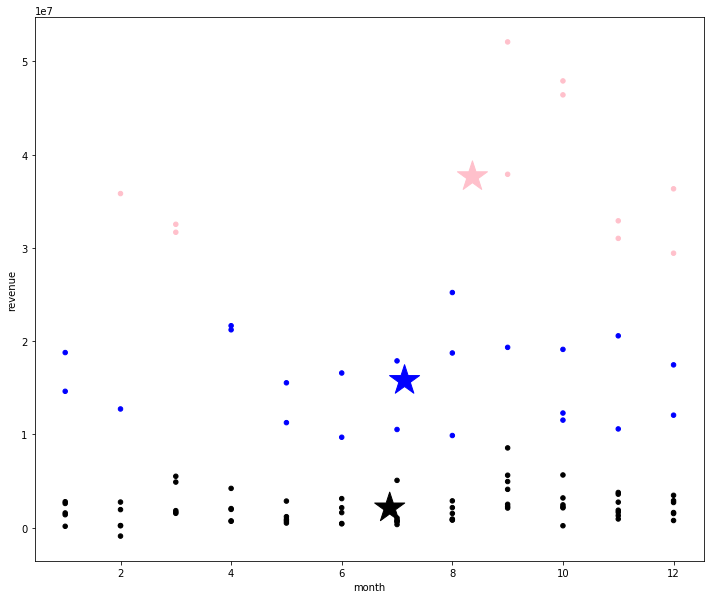

In [43]:
plt.figure(figsize =(10, 8))
colors = ["black", "pink", "blue"]
df["color"] = df["cluster"].map(lambda p: colors[p])

ax = df.plot(kind = "scatter", x = "month", y = "revenue",
    figsize =(12, 10),
    c = df["color"])

centroid.plot(kind = "scatter", x = "month", y = "revenue", 
    marker = "*", 
    c = ["black", "pink", "blue"], 
    s = 1000,
    ax = ax)

Scaling Methodology:

1. Set up StandardScaller
2. Set up X feature and transforming it
3. Set up KMeans
4. Fitting
5. Assinging next round of clusters
6. Creating a df for next round of centroids
7. Plotting

In [44]:
ss = StandardScaler()

In [45]:
X_2 = ss.fit_transform(df.loc[:, ["month", "revenue"]])

In [47]:
km_2 = KMeans(n_clusters = 3)

In [48]:
km_2.fit(X_2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [49]:
df['cluster'] = km_2.labels_

In [50]:
df.head(10)

,state,month,year,handle,revenue,taxes,cluster,color
0,NJ,1,2019,385279662.0,18777582,2532619,0,blue
1,NJ,2,2019,320368087.0,12732740,1817553,0,blue
2,NJ,3,2019,372451342.0,31669387,4180051,2,pink
3,NJ,4,2019,313719562.0,21215747,2817206,0,blue
4,NJ,5,2019,318940677.0,15536384,2135704,0,blue
5,NJ,6,2019,273222975.0,9701925,1258541,0,blue
6,NJ,7,2019,251371272.0,17884790,2367745,1,blue
7,NJ,8,2019,293594862.0,25210342,3327589,2,blue
8,NJ,9,2019,445563503.0,37883375,5017875,2,pink
9,NJ,10,2019,487924504.0,46393537,5662148,2,pink


In [51]:
centroid = pd.DataFrame(ss.inverse_transform(km_2.cluster_centers_), 
      columns =["month", "revenue"])

In [52]:
centroid.head(10) 

,month,revenue
0,3.564103,4.975514e+06
1,9.540000,5.458175e+06
2,8.333333,3.659259e+07


<Figure size 720x432 with 0 Axes>

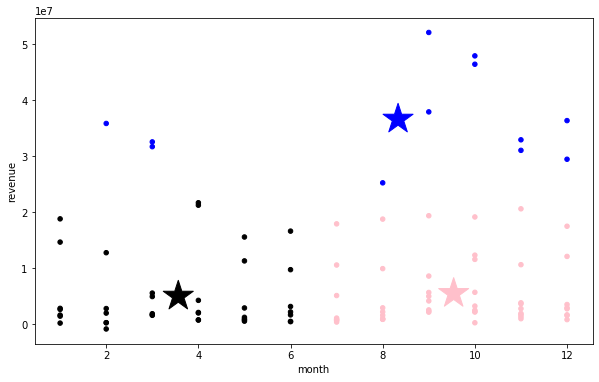

In [54]:
plt.figure(figsize=(10,6))

colors = ["black", "pink", "blue"]

df['color'] = df['cluster'].map(lambda p: colors[p])

ax = df.plot(    
    kind = "scatter",  x = "month", y = "revenue", 
    figsize = (10,6),
    c = df["color"])

centroid.plot(kind = "scatter", x ="month", y = "revenue",
    marker = "*", 
    c = ["black", "pink", "blue"],
    s = 1000,
    ax = ax)

In [55]:
silhouette_score(X_2, km_2.labels_)

0.47801145951363855